In [32]:
import pandas as pd
import numpy as np
df = pd.read_csv("Water_Temp_Strain.txt",sep='\t',header=None)
df.rename(columns={0: 'W_Level_m'}, inplace=True)
df.rename(columns={1: 'Temp_c'}, inplace=True)
df.rename(columns={2: 'micro_strain'}, inplace=True)

#add time component to data frame
delta_t = 144 #min 
t_st = 0
t_fi = delta_t*(len(df)-1)
time_array = np.linspace(t_st, t_fi, len(df), endpoint=True)
df.insert (0, "t_minute", time_array)
df

,t_minute,W_Level_m,Temp_c,micro_strain
0,0.0,-7.317645,0.372449,16.774547
1,144.0,-7.232018,-0.754370,19.498479
2,288.0,-6.477226,1.109975,49.871754
3,432.0,-7.146589,1.569678,28.395637
4,576.0,-7.253274,4.265809,10.035322
...,...,...,...,...
3646,525024.0,-7.860808,0.752731,-0.671496
3647,525168.0,-7.803942,-1.444742,-1.995406
3648,525312.0,-7.721651,-1.365997,-21.020292
3649,525456.0,-8.085533,1.090953,-6.944226


In [33]:
#strain W_Level_m
#df = df[df['W_Level_m']<=df['W_Level_m'].quantile(0.975)]
#df = df[df['W_Level_m']>=df['W_Level_m'].quantile(0.025)]
#strain Temp_c
#df = df[df['Temp_c']<=df['Temp_c'].quantile(0.975)]
#df = df[df['Temp_c']>=df['Temp_c'].quantile(0.025)]
#strain micro_strain
#df = df[df['micro_strain']<=df['micro_strain'].quantile(0.975)]
#df = df[df['micro_strain']>=df['micro_strain'].quantile(0.025)]
#len(df)

In [34]:
#form a matrix y
y = df['micro_strain'].to_numpy()
#y = np.transpose(y)
#form a matrix A
df["1"]=1
A = df[["t_minute","1","Temp_c","W_Level_m"]].to_numpy()
#A = np.transpose(A)
print("This is y")
print(y)
print("This is A")
print(A)


This is y
[ 16.77454715  19.49847855  49.87175411 ... -21.02029241  -6.94422611
   4.80705458]
This is A
[[ 0.00000000e+00  1.00000000e+00  3.72449496e-01 -7.31764510e+00]
 [ 1.44000000e+02  1.00000000e+00 -7.54370183e-01 -7.23201755e+00]
 [ 2.88000000e+02  1.00000000e+00  1.10997522e+00 -6.47722629e+00]
 ...
 [ 5.25312000e+05  1.00000000e+00 -1.36599656e+00 -7.72165131e+00]
 [ 5.25456000e+05  1.00000000e+00  1.09095295e+00 -8.08553348e+00]
 [ 5.25600000e+05  1.00000000e+00  4.21902384e+00 -7.66052752e+00]]


In [35]:
#form a A_transpose
A_transpose = np.transpose(A)
print("This is A_transpose")
print(A_transpose)
#form a A_plus
A_plus = np.matmul(np.linalg.inv(np.matmul(A_transpose,A)),A_transpose)
w_hat = np.matmul(A_plus,y)
print("This is w_hat")
print(w_hat)


This is A_transpose
[[ 0.00000000e+00  1.44000000e+02  2.88000000e+02 ...  5.25312000e+05
   5.25456000e+05  5.25600000e+05]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [ 3.72449496e-01 -7.54370183e-01  1.10997522e+00 ... -1.36599656e+00
   1.09095295e+00  4.21902384e+00]
 [-7.31764510e+00 -7.23201755e+00 -6.47722629e+00 ... -7.72165131e+00
  -8.08553348e+00 -7.66052752e+00]]
This is w_hat
[-4.29842638e-04 -4.39502381e+02  1.44327434e+00 -5.31572336e+01]


In [36]:
alph = w_hat[0]
beta = w_hat[1]
gamm = w_hat[2]
delt = w_hat[3]

In [37]:
def q_t(time):
    q = alph*time+beta
    return q
q_t(3000)

-440.79190912183117

In [38]:
def min_from_year(y):
    minute = y*365*24*60
    return minute
q_t(min_from_year(5))

-1569.1288341221095

In [39]:
#residual
r = y - np.matmul(A,w_hat)
df['r']=r
print(r)

[ 66.75361104  75.71747367 143.58450021 ... 235.79346946 227.04241163
 256.93306619]


In [40]:
df.head(10).style.format('{0:,.2f}')

,t_minute,W_Level_m,Temp_c,micro_strain,1,r
0,0.00,-7.32,0.37,16.77,1.00,66.75
1,144.00,-7.23,-0.75,19.50,1.00,75.72
2,288.00,-6.48,1.11,49.87,1.00,143.58
3,432.00,-7.15,1.57,28.40,1.00,85.93
4,576.00,-7.25,4.27,10.04,1.00,58.06
5,720.00,-7.44,-1.34,5.51,1.00,51.91
6,864.00,-6.63,-3.53,-8.19,1.00,84.12
7,"1,008.00",-7.17,-1.89,18.84,1.00,80.28
8,"1,152.00",-6.87,-1.36,4.11,1.00,80.91
9,"1,296.00",-6.76,-1.21,20.30,1.00,102.52


<AxesSubplot:xlabel='t_minute', ylabel='r'>

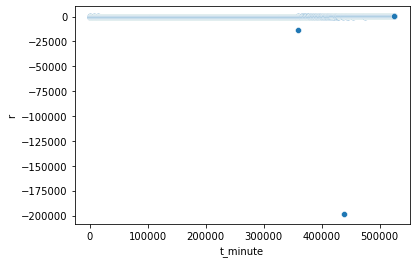

In [41]:
import seaborn as sns
sns.scatterplot(data=df, x="t_minute", y="r")

In [42]:
#create a loop
df_e = df
df_garbage = pd.DataFrame(columns=df_e.columns)
outliner = 1
while outliner >0:
    #compute r_mean and r_stdv
    r_mean = df_e['r'].mean()
    r_stdv = df_e['r'].std()
    #compute d_i
    df_e['d'] = np.absolute(df_e['r'].to_numpy()-r_mean)/r_stdv
    #collect garbage
    df_tempo = df_e[df_e['d']>3]
    df_garbage = df_garbage.append(df_tempo)
    #remove outliners
    df_e = df_e[df_e['d']<=3]
    outliner = len(df_tempo)
    print(outliner)
    #repeat regression
    A = df_e[["t_minute","1","Temp_c","W_Level_m"]].to_numpy()
    y = df_e['micro_strain'].to_numpy()
    A_transpose = np.transpose(A)
    A_plus = np.matmul(np.linalg.inv(np.matmul(A_transpose,A)),A_transpose)
    w_hat = np.matmul(A_plus,y)
    r = y - np.matmul(A,w_hat)
    df_e['r']=r
df_garbage

2
11
3
0


<ipython-input-42-399648d659a6>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_e['r']=r
<ipython-input-42-399648d659a6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_e['d'] = np.absolute(df_e['r'].to_numpy()-r_mean)/r_stdv


,t_minute,W_Level_m,Temp_c,micro_strain,1,r,d
2499,359856.0,-9.546883,4.179788,-13249.534019,1,-13168.868657,3.997892
3049,439056.0,-8.371391,2.103995,-198650.876347,1,-198470.685617,60.253042
49,7056.0,-7.063081,0.455863,162.453175,1,142.538420,10.174023
199,28656.0,-8.437181,4.772817,108.528192,1,81.751969,5.835244
349,50256.0,-8.590828,9.051048,130.877250,1,98.125352,7.003933
499,71856.0,-9.240080,13.418814,149.463749,1,110.260252,7.870091
598,86112.0,-10.193976,10.521659,-7.699263,1,-42.415161,3.027484
599,86256.0,-9.198203,14.526011,129.261561,1,88.919337,6.346832
2199,316656.0,-10.211957,10.884456,-79.225111,1,-105.297673,7.515875
2959,426096.0,-9.841165,2.073174,-159.829039,1,-167.397216,11.948379


In [43]:
df_e['r'].describe()

count    3.635000e+03
mean    -2.116936e-13
std      1.177409e+01
min     -3.463404e+01
25%     -7.951962e+00
50%      3.046453e-02
75%      8.076573e+00
max      3.528720e+01
Name: r, dtype: float64

<AxesSubplot:xlabel='t_minute', ylabel='r'>

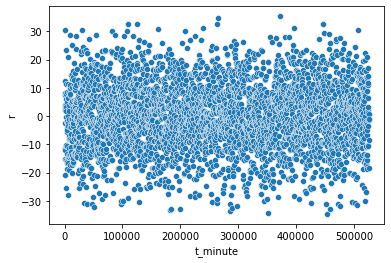

In [44]:
sns.scatterplot(data=df_e, x="t_minute", y="r")

In [45]:
w_hat

array([-3.75975974e-05,  1.14879353e+01,  1.55176808e+00, -9.86864597e-01])

In [46]:
alph = w_hat[0]
beta = w_hat[1]
gamm = w_hat[2]
delt = w_hat[3]
print(q_t(3000))
print(q_t(min_from_year(5)))

11.375142474904486
-87.31855079377345
